In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from xgboost import XGBClassifier

# Configurar Kaggle
import os
os.environ['KAGGLE_CONFIG_DIR'] = '.'
!chmod 600 kaggle.json

# Descargar y descomprimir los datos
!kaggle competitions download -c udea-ai-4-eng-20251-pruebas-saber-pro-colombia
!unzip udea*.zip > /dev/null
!wc *.csv

  0% 0.00/29.9M [00:00<?, ?B/s]
100% 29.9M/29.9M [00:00<00:00, 1.17GB/s]
replace submission_example.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:    296787    296787   4716673 submission_example.csv
   296787   4565553  59185250 test.csv
   692501  10666231 143732449 train.csv
  1286075  15528571 207634372 total


Train shape: (692500, 21)
Test shape: (296786, 20)
Train accuracy: 0.39628158844765343
Test accuracy: 0.39542238267148017


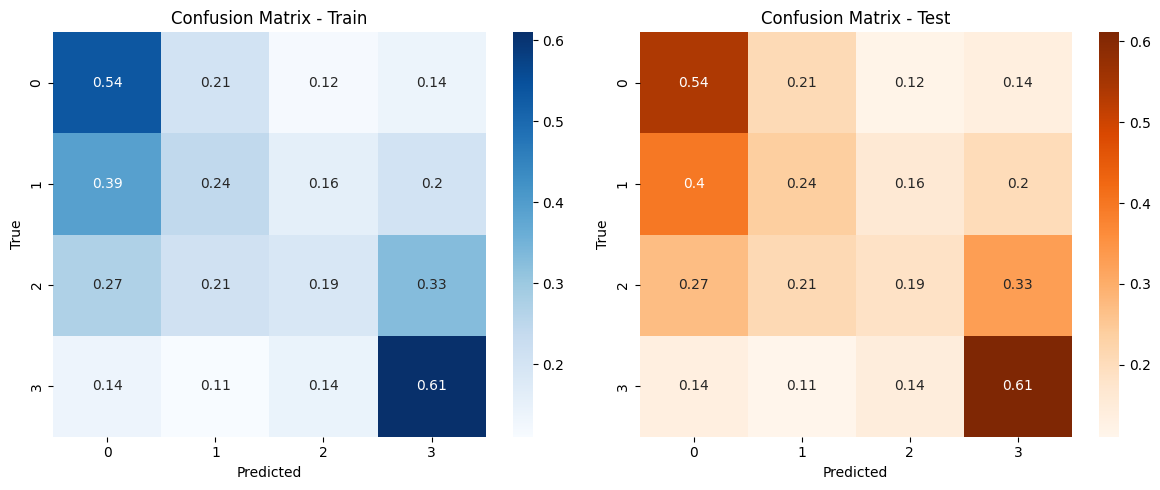

In [ ]:
# ======================
# 📥 CARGA DE LOS DATOS
# ======================

z = pd.read_csv("train.csv")
zt = pd.read_csv("test.csv")
print("Train shape:", z.shape)
print("Test shape:", zt.shape)

# Mapeo de la variable objetivo
rmap = {'bajo': 0, 'medio-bajo': 1, 'medio-alto': 2, 'alto': 3}
z['RENDIMIENTO_GLOBAL'] = z['RENDIMIENTO_GLOBAL'].map(rmap)

# ✅ Variables seleccionadas (añadimos la nueva)
features = [
    'ESTU_VALORMATRICULAUNIVERSIDAD',
    'ESTU_HORASSEMANATRABAJA',
    'FAMI_ESTRATOVIVIENDA',
    'FAMI_TIENEINTERNET',
    'FAMI_EDUCACIONPADRE',
    'FAMI_TIENELAVADORA',
    'FAMI_TIENEAUTOMOVIL',
    'FAMI_TIENECOMPUTADOR',
    'FAMI_EDUCACIONMADRE',
    'ESTU_PAGOMATRICULAPROPIO'
]
target = 'RENDIMIENTO_GLOBAL'

# Rellenar nulos
z[features] = z[features].fillna("no info")

# Mapear variable numérica
map_valor = {
    'Entre 1 millón y menos de 2.5 millones': 1.75,
    'Entre 2.5 millones y menos de 4 millones': 3.25,
    'Menos de 500 mil': 0.25,
    'Entre 500 mil y menos de 1 millón': 0.75,
    'Entre 4 millones y menos de 5.5 millones': 4.75,
    'Más de 7 millones': 7.75,
    'Entre 5.5 millones y menos de 7 millones': 6.25,
    'No pagó matrícula': 0,
    'no info': -1
}
z['ESTU_VALORMATRICULAUNIVERSIDAD'] = z['ESTU_VALORMATRICULAUNIVERSIDAD'].map(map_valor)

# Convertir columnas categóricas a tipo categoría
cat_features = [col for col in features if z[col].dtype == 'object' or str(z[col].dtype) == 'category']
for col in cat_features:
    z[col] = z[col].astype('category')

# One-hot encoding para categóricas
z_encoded = pd.get_dummies(z[features], columns=cat_features)

# Separar X e y
X = z_encoded
y = z[target]

# Split entrenamiento/prueba
Xtr, Xts, ytr, yts = train_test_split(X, y, train_size=0.8, random_state=42)

# Entrenamiento del modelo XGBoost
xgb = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    eval_metric='mlogloss',
    random_state=42,
    enable_categorical=True
)

xgb.fit(Xtr, ytr)

# Predicciones
preds_tr = xgb.predict(Xtr)
preds_ts = xgb.predict(Xts)

# Métricas
print("Train accuracy:", accuracy_score(ytr, preds_tr))
print("Test accuracy:", accuracy_score(yts, preds_ts))

# Matrices de confusión
cm_tr = confusion_matrix(ytr, preds_tr, normalize='true')
cm_ts = confusion_matrix(yts, preds_ts, normalize='true')

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm_tr, annot=True, cmap='Blues', ax=axes[0])
axes[0].set_title("Confusion Matrix - Train")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

sns.heatmap(cm_ts, annot=True, cmap='Oranges', ax=axes[1])
axes[1].set_title("Confusion Matrix - Test")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

plt.tight_layout()
plt.show()

# ============================
# 📤 Preprocesamiento del test
# ============================

zt['ESTU_VALORMATRICULAUNIVERSIDAD'] = zt['ESTU_VALORMATRICULAUNIVERSIDAD'].map(map_valor)
zt[features] = zt[features].fillna("no info")

# Asegurar tipos categóricos
for col in cat_features:
    zt[col] = zt[col].astype('category')

# Encoding y alineación
zt_encoded = pd.get_dummies(zt[features], columns=cat_features)
zt_encoded = zt_encoded.reindex(columns=X.columns, fill_value=0)

# Asegurar que todas las columnas sean numéricas
object_cols = zt_encoded.select_dtypes(include=['object']).columns
for col in object_cols:
    zt_encoded[col] = pd.to_numeric(zt_encoded[col], errors='coerce')
    zt_encoded[col] = zt_encoded[col].fillna(zt_encoded[col].mean())

# Predicciones
preds_test = xgb.predict(zt_encoded)
rmapi = {v: k for k, v in rmap.items()}
text_preds = [rmapi[p] for p in preds_test]

In [ ]:
submission = pd.DataFrame({
    'ID': zt['ID'],
    'RENDIMIENTO_GLOBAL': text_preds
})
submission.to_csv("submission.csv", index=False)
!head submission.csv

ID,RENDIMIENTO_GLOBAL
550236,alto
98545,medio-alto
499179,medio-bajo
782980,bajo
785185,medio-bajo
58495,bajo
705444,alto
557548,alto
519909,bajo
